In [1]:
#Imagine we are tasked with building a model that predicts whether a customer will renew their product subscription. 
#Let’s assume that after a bit of digging we manage to get eight features which are important for predicting churn: 
#customer discount, ad spending, customer’s monthly usage, last upgrade, bugs reported by a customer, interactions with a customer, 
#sales calls with a customer, and macroeconomic activity. We then use those features to train a basic XGBoost model to predict 
#if a customer will renew their subscription when it expires:

# This cell defines the functions we use to generate the data in our scenario

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost


class FixableDataFrame(pd.DataFrame):
    """Helper class for manipulating generative models."""

    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super().__init__(*args, **kwargs)

    def __setitem__(self, key, value):
        out = super().__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super().__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out


# generate the data
def generator(n, fixed={}, seed=0):
    """The generative model for our subscriber retention example."""
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # the number of sales calls made to this customer
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # the number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # the health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # the time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # how much the user perceives that they need the product
    X["Product need"] = X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,))

    # the fractional discount offered to this customer upon renewal
    X["Discount"] = ((1 - scipy.special.expit(X["Product need"])) * 0.5 + 0.5 * np.random.uniform(0, 1, size=(n,))) / 2

    # What percent of the days in the last period was the user actively using the product
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,)))

    # how much ad money we spent per user targeted at this user (or a group this user is in)
    X["Ad spend"] = (
        X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,)) + (X["Last upgrade"] < 1) + (X["Last upgrade"] < 2)
    )

    # how many bugs did this user encounter in the since their last renewal
    X["Bugs faced"] = np.array([np.random.poisson(v * 2) for v in X["Monthly usage"]])

    # how many bugs did the user report?
    X["Bugs reported"] = (X["Bugs faced"] * scipy.special.expit(X["Product need"])).round()

    # did the user renew?
    X["Did renew"] = scipy.special.expit(
        7
        * (
            0.18 * X["Product need"]
            + 0.08 * X["Monthly usage"]
            + 0.1 * X["Economy"]
            + 0.05 * X["Discount"]
            + 0.05 * np.random.normal(0, 1, size=(n,))
            + 0.05 * (1 - X["Bugs faced"] / 20)
            + 0.005 * X["Sales calls"]
            + 0.015 * X["Interactions"]
            + 0.1 / (X["Last upgrade"] / 4 + 0.25)
            + X["Ad spend"] * 0.0
            - 0.45
        )
    )

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Uncomment this line to get
    # noiser causal effect lines but the same basic results
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X


def user_retention_dataset():
    """The observed data for model training."""
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    #drop hidden features that we don’t measure as well as the target variable
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y


def fit_xgboost(X, y):
    """Train an XGBoost model with early stopping."""
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        {"eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"},
        dtrain,
        num_boost_round=200000,
        evals=((dtest, "test"),),
        early_stopping_rounds=20,
        verbose_eval=False,
    )
    return model

In [2]:
X, y = user_retention_dataset()
model = fit_xgboost(X, y)

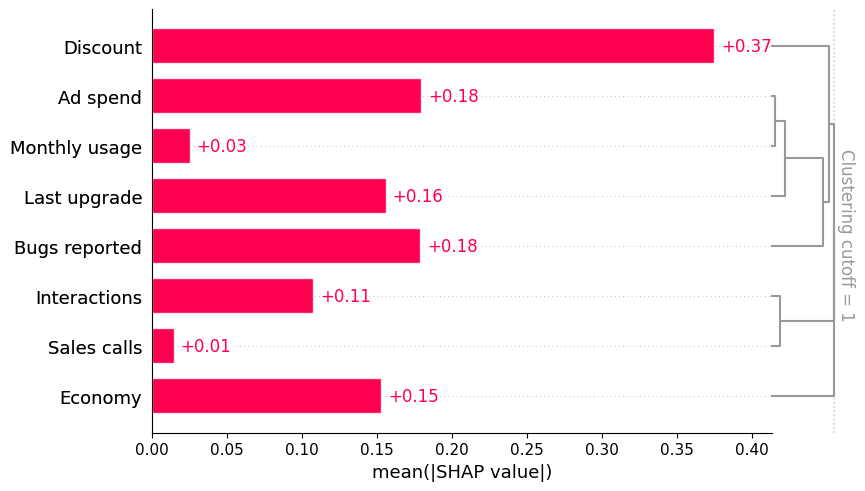

In [3]:
#global importance of each feature in the model

import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

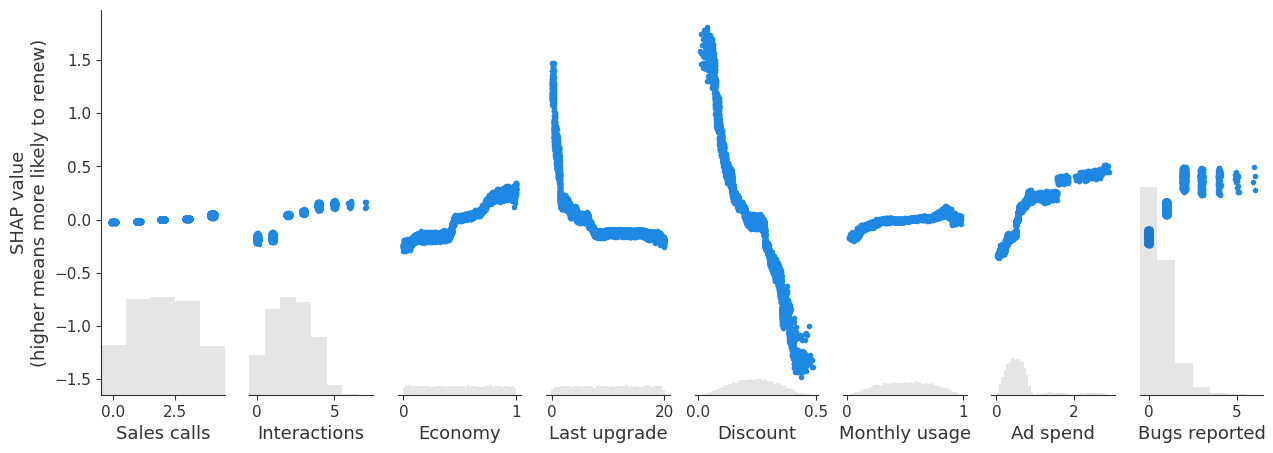

In [4]:
#SHAP scatter plots show how changing the value of a feature impacts the model’s prediction of renewal probabilities
#there are some unintuitive patterns - like discount or bugs reported
#explanation: The sales force tends to give high discounts to customers they think are less likely to be interested in the product, 
#and these customers have higher churn.
shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")
#goal of predictive model: good fit out-of-sample, therefore relationships like bugs reported are helpful for prediction purpose
#--> in such cases the direction of relationship is irrelevant

#But for other questions: "what actions our company can take to retain more customers?"
#--> direction is important --> counterfactual scenario --> cause and effect?

Looking in indexes: https://packages.repo.dvint.de/artifactory/api/pypi/py-mirror/simple/

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


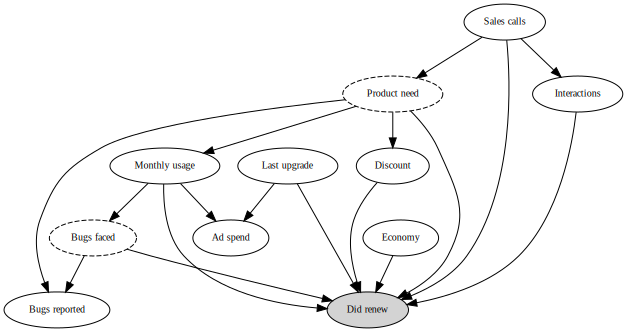

In [5]:
#for causal tasks we can look at a causal graph of the data generating process
#Each feature is a function of all the features with an arrow to it, plus some random effects.
#must be designed by context-specific domain knowledge about how the world works to infer which relationships can or cannot exist

%pip install graphviz
import graphviz

names = [
    "Bugs reported",
    "Monthly usage",
    "Sales calls",
    "Economy",
    "Discount",
    "Last upgrade",
    "Ad spend",
    "Interactions",
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Did renew", style="filled", fontsize="10")

g.edge("Product need", "Did renew")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Did renew")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Did renew")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Did renew")
g.edge("Sales calls", "Did renew")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Did renew")
g.edge("Bugs faced", "Did renew")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Did renew")
g.edge("Last upgrade", "Ad spend")

g


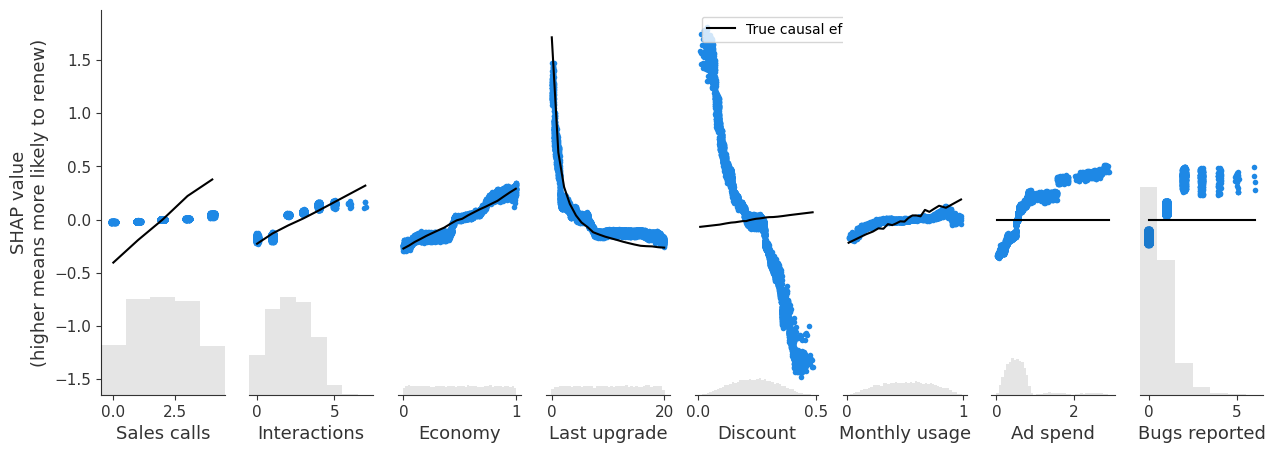

In [6]:
#Product need and Bugs faced define unmeasured confounding features.



#he figure below plots the SHAP values in our example against the true causal effect of each feature 
#(known in this example since we generated the data).

def marginal_effects(generative_model, num_samples=100, columns=None, max_points=20, logit=True, seed=0):
    """Helper function to compute the true marginal causal effects."""
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i, c in enumerate(columns):
        xs[i] = np.unique([np.nanpercentile(xs[i], v, method="nearest") for v in np.linspace(0, 100, max_points)])
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Did renew"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))


shap.plots.scatter(
    shap_values,
    ylabel="SHAP value\n(higher means more likely to renew)",
    overlay={"True causal effects": marginal_effects(generator, 10000, X.columns)})

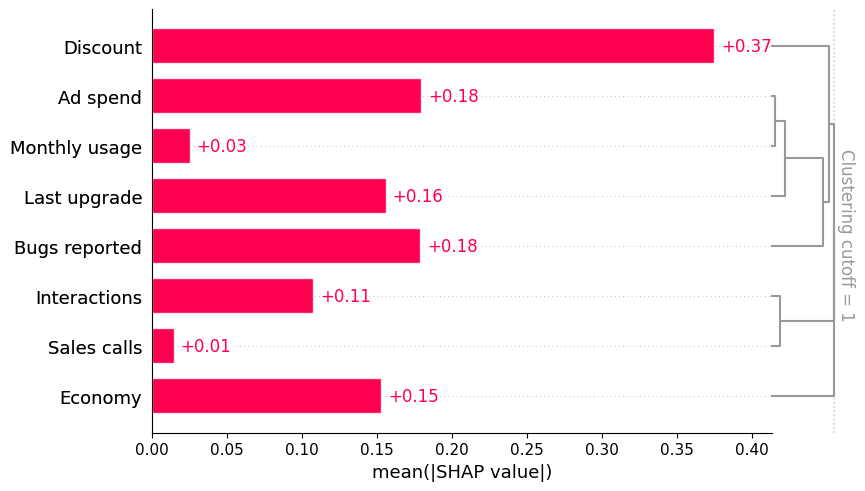

In [7]:
#The predictive model captures an overall positive effect of bugs reported on retention (as shown with SHAP), 
#even though the causal effect of reporting a bug is zero, and the effect of encoutering a bug is negative.
#The correlation we end up capturing in predictive models between bugs reported and renewal combines 
#a small negative direct effect of bugs faced and a large positive confounding effect from product need.
#Conditioning on Product need would help us analyzing the true relationship (cause and effect) between Bugs reported and Renewal 
#(conditional independence between Bugs reported and renewal given Product need) 
#--> there is no relationship between bugs reported and renewal when looking at customers with same product need (which is unobserved)
#--> Discount feature as analogon --> we call this unobserved confounding problem

#-->we can also have an observed confounding problem, like with the feature Ad Spend
#--> statistical redundancy between Ad Spend and features that influence Ad Spend. Ad Spend is correlated with other features that 
#causally drive renewal --> regularized models summarize multiple causal drivers (sparse model)
# Economy is independent of other measured features.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

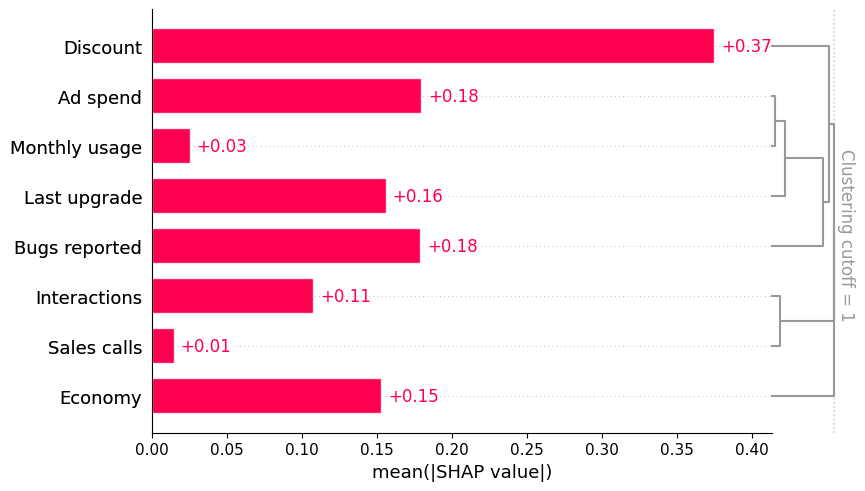

In [8]:
# Ad spend is very redundant with Monthly usage and Last upgrade.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

# XGBoost captures causal dependence of features Economy well, as it is stronlgy idenpendent (of other measured features 
# and unmeasured confounders (see dendrogramm, no feature redundancy on top right, redundancy on bottom left --> interchangable w.r.t correlation with target).
#--> Economy does not suffer from observed confounding!

#--> Check for unmeasured confounding is much harder and requrires domain knowledge!

#--> For classic predictive ML models to deliver causal results the features need to be independent 
#not only of other features in the model, but also of unobserved confounders (not realistic in "natural data", but in data coming from experiments!)

In [9]:
#Causal inference to rescue?
#Can we disentangle observed confounding (the relationships that i.e. confound Ad Spend) to get unconfounded estimate
#of causal effect of Ad Spend on product renewal?
#--> use observational causal inference! (i.e. double/debiased Machine Learning)
#--> first deconfound the feature of interest (i.e. Ad Spend), again via ML,
#and then estimate the average causal effect of changing that feature (i.e. the average slope of the causal effect)
# underlying theory is FWL (Frisch Waugh Lovell theorem)
#FWL: 1)Separately regress y on X and T on X
#     2)Save the residuals from step 1— call it **y*** and **T***
#     3)Regress **y*** on **T***

#i.e.:  1. Train a model to predict a feature of interest (i.e. Ad Spend) using a set of possible confounders 
#(i.e. any features not caused by Ad Spend). 
#2. Train a model to predict the outcome (i.e. Did Renew) using the same set of possible confounders. 
#3. Train a model to predict the residual variation of the outcome (the variation left after subtracting our prediction) 
#using the residual variation of the causal feature of interest.

#Intuitively: Does the part of variance in Ad Spend which cannot be predicted (explained) by the "controlled variables" a.k.a. confounders
#significantly correlate with the part of variance in Prduct Renewal which cannot be predicted (explained) by those confounders.
#in other words:  double ML assumes that there is an independent (unobserved) noise feature that impacts Ad Spend 
#(since Ad Spend is not perfectly determined by the other features), so we can impute the value of this independent noise feature 
#and then train a model on this independent feature to predict the output.
#--> use causal inference packages like econml or CausalMl

%pip install econml

import matplotlib.pyplot as plt
from econml.dml import LinearDML
from sklearn.base import BaseEstimator, clone


class RegressionWrapper(BaseEstimator):
    """Turns a classifier into a 'regressor'.

    We use the regression formulation of double ML, so we need to approximate the classifer
    as a regression model. This treats the probabilities as just quantitative value targets
    for least squares regression, but it turns out to be a reasonable approximation.
    """

    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y, **kwargs):
        self.clf_ = clone(self.clf)
        self.clf_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.clf_.predict_proba(X)[:, 1]


# Run Double ML, controlling for all the other features
def double_ml(y, causal_feature, control_features):
    """Use doubleML from econML to estimate the slope of the causal effect of a feature."""
    xgb_model = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
    est = LinearDML(model_y=RegressionWrapper(xgb_model))
    est.fit(y, causal_feature, W=control_features)
    return est.effect_inference()

# Run Double ML with statistics as return, controlling for all the other features
def double_ml_summary(y, causal_feature, control_features):
    """Use doubleML from econML to estimate the slope of the causal effect of a feature."""
    xgb_model = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
    est = LinearDML(model_y=RegressionWrapper(xgb_model))
    est.fit(y, causal_feature, W=control_features)
    return est.summary()


def plot_effect(effect, xs, x_label, true_ys, ylim=None):
    """Plot a double ML effect estimate from econML as a line.

    Note that the effect estimate from double ML is an average effect *slope* not a full
    function. So we arbitrarily draw the slope of the line as passing through the origin.
    """
    plt.figure(figsize=(5, 3))

    pred_xs = [xs.min(), xs.max()]
    mid = (xs.min() + xs.max()) / 2
    [effect.pred[0] * (xs.min() - mid), effect.pred[0] * (xs.max() - mid)]

    plt.plot(xs, true_ys - true_ys[0], label="True causal effect", color="black", linewidth=3)
    point_pred = effect.point_estimate * pred_xs
    pred_stderr = effect.stderr * np.abs(pred_xs)
    plt.plot(
        pred_xs,
        point_pred - point_pred[0],
        label="Double ML slope",
        color=shap.plots.colors.blue_rgb,
        linewidth=3,
    )
    # 99.9% CI
    plt.fill_between(
        pred_xs,
        point_pred - point_pred[0] - 3.291 * pred_stderr,
        point_pred - point_pred[0] + 3.291 * pred_stderr,
        alpha=0.2,
        color=shap.plots.colors.blue_rgb,
    )
    plt.legend()
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel("Zero centered effect")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.gca().xaxis.set_ticks_position("bottom")
    plt.gca().yaxis.set_ticks_position("left")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.show()



Looking in indexes: https://packages.repo.dvint.de/artifactory/api/pypi/py-mirror/simple/

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


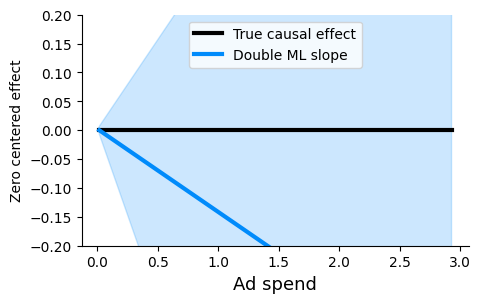

In [10]:
# estimate the causal effect of Ad spend controlling for certain features
# double ML (or any other observational causal inference method) only works when you can measure and identify all the possible 
# confounders of the feature for which you want to estimate causal effects.
# we know the features either from Causal graph (here) but otherwise we could derive them using SHAP dendrograms

causal_feature = "Ad spend"
x_label = causal_feature
control_features = [
    #"Sales calls",
    #"Interactions",
    #"Economy",
    "Last upgrade",
    #"Discount",
    "Monthly usage",
    #"Bugs reported",
]
effect = double_ml(y, X[causal_feature], X.loc[:, control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[["Ad spend"]], logit=False)[0]
plot_effect(effect, xs, x_label, true_ys, ylim=(-0.2, 0.2))

In [11]:
#results: average slope of the causal effect -> high confidence interval --> pvalue see below
#effects=double_ml(y, X[causal_feature], X.loc[:, control_features])

In [12]:
X.loc[:, control_features]

,Last upgrade,Monthly usage
0,17.036984,0.825265
1,13.464172,0.287509
2,1.631930,0.433489
3,7.710981,0.235349
4,6.391478,0.824211
...,...,...
9995,10.540743,0.373962
9996,1.878001,0.543083
9997,11.794950,0.245795
9998,12.251466,0.271200


In [13]:
#effects=double_ml_summary(y, X[causal_feature], X.loc[:, control_features])

In [14]:
# P-value of whether that treatment has a non-zero causal effect --> no significant causal effect 
effect.pvalue()

array([0.29705381])

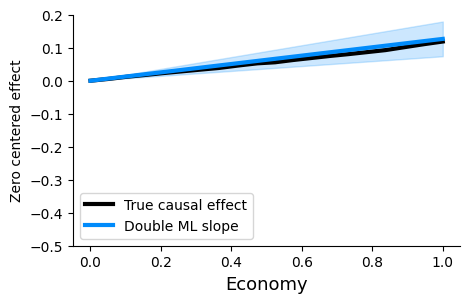

In [15]:
# estimate the causal effect of Economy controlling for all the other features
# we know from SHAP dendrogram (as well as the causal graph) that economy is stronlgy idenpendent (of other measured features 
# and unmeasured confounders (see dendrogramm, no feature redundancy on top right, redundancy on bottom left --> interchangable w.r.t correlation with target).
#--> Economy does not suffer from observed confounding! 
causal_feature = "Economy"
x_label = causal_feature
control_features = [
    "Sales calls",
    "Interactions",
    "Discount",
    "Last upgrade",
    "Monthly usage",
    "Ad spend",
    "Bugs reported",
]
effect = double_ml(y, X[causal_feature], X.loc[:, control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[[causal_feature]], logit=False)[0]
plot_effect(effect, xs, x_label, true_ys, ylim=(-0.5, 0.2))

In [16]:
#results: average slope of the causal effect -> low confidence interval --> pvalue low --> DML captures slight positive causal effect
effect.pvalue()

array([2.24992704e-15])

In [17]:
#Now lets go away from Observational Causal Inference and move to Non-confoundig redundancy where Causal Inference can help as well

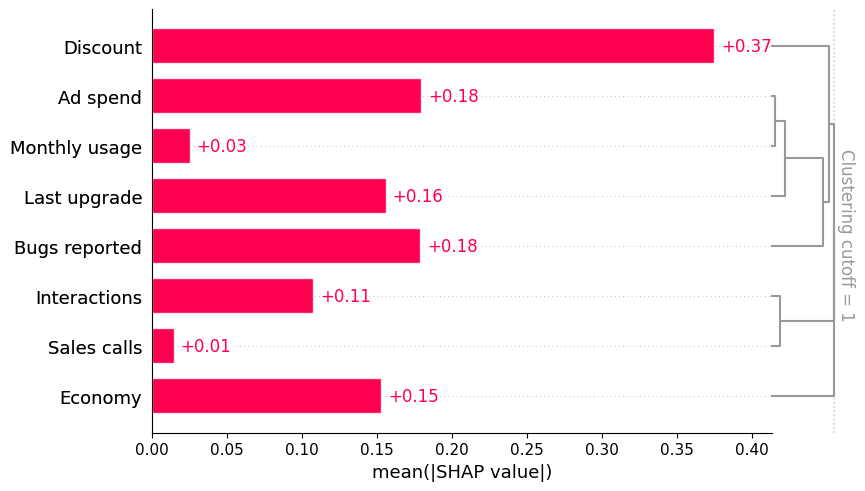

In [18]:
# Interactions and sales calls are very redundant with one another.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [19]:
# From Shap (marginal effects) we see that XGboost underestimates true causal effect from Sales and attributes much to "Interactions"
# --> Non-confounding redundancy can be fixed in principle by removing the redundant variables from the model
# --> that is also important for double ML, as it will fail to capture indirect causal effects if you control for downstream features 
# caused by the feature of interest
# Double ML, however robust to controlling for upstream non-confounding redundancy 
#   (where the redundant feature causes the feature of interest), though this will reduce your statistical power to detect true effects.

# Important question: When we dont know the true causal graph, do we have feature redundancy with feature of interest due to
# observed confounding or due to non-confounding redundancy. So which feautures to drop or control for in a ML setting to measure true
# and full causal effects?
# --> if we control for a feauture we shouldn't that might hide or split up the true causal effect
# --> if we fail to control for a feature we should that might infer causal effects that do not exist
# --> if we are uncertain, controlling for a feature could be the safer option

#--> in a nutshell our goal (when iteratively using ML + XAi + Causal Inference like Double ML) is to construct an ML model 
# (by controlling for oberved confouders (Double ML) or dropping redundant features) that purely relies on/learns the true causal effects.

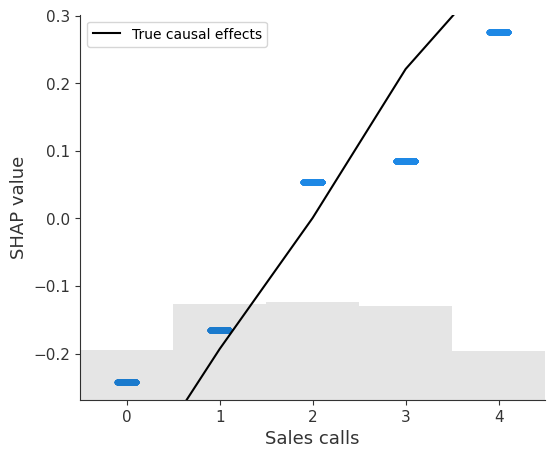

In [20]:
# Fit, explain, and plot a univariate model with just Sales calls
# Note how this model does not have to split of credit between Sales calls and
# Interactions, so we get a better agreement with the true causal effect.
sales_calls_model = fit_xgboost(X[["Sales calls"]], y)
sales_calls_shap_values = shap.Explainer(sales_calls_model)(X[["Sales calls"]])
shap.plots.scatter(
    sales_calls_shap_values,
    overlay={"True causal effects": marginal_effects(generator, 10000, ["Sales calls"])},)

In [21]:
# When neither predictive models nor unconfounding methods can answer causal questions!?!

#Double ML (or any other causal inference method that assumes unconfoundedness) only works when you can measure and identify 
# all the possible confounders of the feature for which you want to estimate causal effects

#--> otherwise we are confronted with UNOBSERVED CONFOUNDING which is the hardest scenario

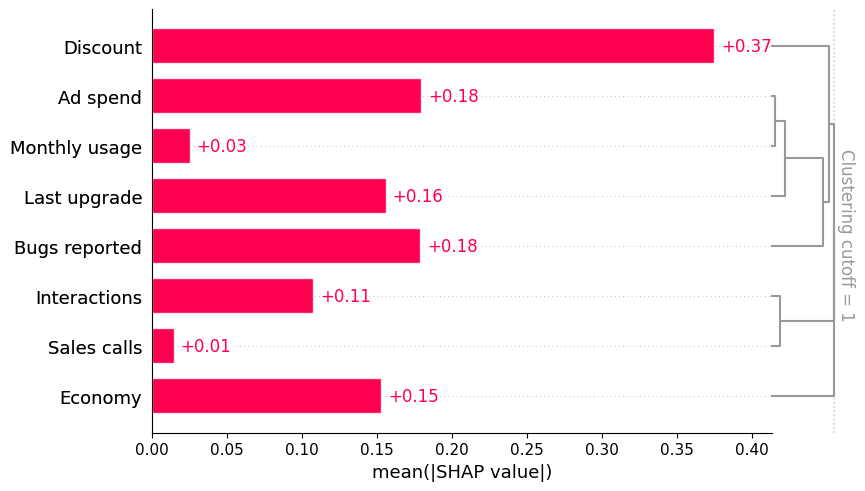

In [22]:
# Discount seems fairly independent of the other features WE CAN MEASURE acc. to SHAP dendrogramm 
# that could imply a modelled causal effect at least for the measured features
# BUT: we know that Discount is not independent of Product need, which is an unobserved confounder.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

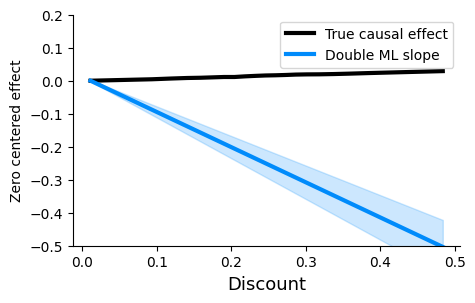

In [23]:
# estimate the causal effect of Discount controlling for all the other features
causal_feature = "Discount"
x_label = causal_feature
control_features = [
    "Sales calls",
    "Interactions",
    "Economy",
    "Last upgrade",
    "Monthly usage",
    "Ad spend",
    "Bugs reported",
]
effect = double_ml(y, X[causal_feature], X.loc[:, control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[[causal_feature]], logit=False)[0]
plot_effect(effect, xs, x_label, true_ys, ylim=(-0.5, 0.2))

In [24]:
#results: average slope of the causal effect -> low confidence interval --> pvalue see below
#effects=double_ml(y, X[causal_feature], X.loc[:, control_features])

In [25]:
#effects=double_ml_summary(y, X[causal_feature], X.loc[:, control_features])

In [26]:
# P-value of whether that treatment has a non-zero causal effect --> according to Double ML there is a significant negative causal effect
# of Discount on Renewal (which is in fact incorrect as Double ML does not work in case of unobserved confounding) 
effect.pvalue()

array([9.57755225e-96])

In [27]:
# For unobserved confounding scenarios, the only way to identify causal effects that can inform policy is to create or exploit 
# some randomization that breaks the correlation between the features of interest and the unmeasured confounders. 
# Randomized experiments remain the gold standard for finding causal effects in this context.
# Specialized causal tools based on the principals of instrumental variables, differences-in-differences, or regression discontinuities
# can sometimes also help us out here

In [28]:
#Summary: Flexible predictive models like XGBoost or LightGBM are powerful tools for solving prediction problems. 
#However, they are not inherently causal models, so interpreting them with SHAP will fail to accurately answer causal questions 
#in many common situations. Unless features in a model are the result of experimental variation, applying SHAP to predictive models 
#without considering confounding is generally not an appropriate tool to measure causal impacts used to inform policy. 
#SHAP and other interpretability tools can be useful for causal inference (especially in the absence of a causal graph), and SHAP is 
#integrated into many causal inference packages, but those use cases are explicitly causal in nature. 
#To that end, using the same data we would collect for prediction problems and 
#using causal inference methods like double ML that are particularly designed to return causal effects is often a good approach for 
#informing policy. In other situations, only an experiment or other source of randomization can really answer what if questions. 
#Causal inference always requires us to make important assumptions. The main point of this article is that the assumptions we make by 
#interpreting a normal predictive model as causal are often unrealistic.